In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import pandas as pd

# Read all sheets
excel_path = "IS453 Group Assignment - Data Dict.xlsx"
xls = pd.ExcelFile(excel_path)

# Display sheet names
print(xls.sheet_names)

# Read each sheet into a DataFrame
df1 = pd.read_excel(xls, xls.sheet_names[0])
df2 = pd.read_excel(xls, xls.sheet_names[1])

# Display basic info
print("Sheet 1 shape:", df1.shape)
print("Sheet 2 shape:", df2.shape)

['Application Data', 'Bureau Data']
Sheet 1 shape: (120, 3)
Sheet 2 shape: (17, 3)


In [3]:

# This was after preprocessing of removing applicant below 60 years
main_df = pd.read_csv("elder_care_segment.csv")

In [4]:
main_df["NAME_INCOME_TYPE"].unique()

array(['Pensioner', 'Working', 'Commercial associate', 'State servant',
       'Unemployed', 'Maternity leave'], dtype=object)

In [5]:
import pandas as pd
main_df = pd.read_csv("merged_applicant_and_bureau.csv")

# Applicant Data – Selected Features

The following features are retained from the applicant dataset for analysis:

## Target Variable
- **TARGET**  
  Binary target variable: 1 = default / risk, 0 = no default / low risk.

## Demographic Features
- **NAME_INCOME_TYPE**  
  Type of income (e.g., Working, Pensioner, State servant).

- **NAME_FAMILY_STATUS**  
  Family status (e.g., Married, Single / not married, Civil marriage).

- **CNT_CHILDREN**  
  Number of children for the applicant.

- **AGE**  
  Age of the applicant (calculated from `DAYS_BIRTH`).

## Financial Features
- **AMT_INCOME_TOTAL**  
  Total annual income of the applicant.

- **AMT_CREDIT**  
  Credit amount requested by the applicant.

- **AMT_ANNUITY**  
  Loan annuity amount (monthly repayment).

- **AMT_GOODS_PRICE**  
  Price of the goods or property to be purchased with the loan.

- **DAYS_EMPLOYED**  
  Days employed in current job (can be negative if data uses `DAYS_EMPLOYED` format as in Home Credit dataset).

## Occupational Features
- **OCCUPATION_TYPE**  
  Typ


# Bureau Final – Selected Features

The following features are retained in `bureau_final` as the most informative for analysis:

## Numeric Aggregated Features
- **AMT_CREDIT_SUM_sum**  
  Total loan amount per person (aggregation of `AMT_CREDIT_SUM`).

- **AMT_CREDIT_SUM_DEBT_sum**  
  Total debt per person (aggregation of `AMT_CREDIT_SUM_DEBT`).

- **AMT_CREDIT_SUM_OVERDUE_max**  
  Maximum overdue amount per person from `AMT_CREDIT_SUM_OVERDUE`.

- **CREDIT_DAY_OVERDUE_max**  
  Maximum days overdue per person from `CREDIT_DAY_OVERDUE`.

- **CNT_CREDIT_PROLONG_sum**  
  Cumulative number of credit prolongations per person.

## Categorical Features (One-Hot or Frequency Encoded)
- **CREDIT_ACTIVE_Active**  
  Number of active loans per person. Value increment of 1 for each active loans existing, otherwise 0.

- **CREDIT_ACTIVE_Closed**  
  Number of closed loans per person. Aggregated count of all closed loans, increment of 1 for each closed loan otherwise 0

- **CREDIT_TYPE_Mortgage**  
  Indicator for mortgage loans.

- **CREDIT_TYPE_Consumer credit**  
  Indicator for consumer credit loans.

- **CREDIT_TYPE_Car loan**  
  Indicator for car loans.

## Derived Features / Ratios
- **DEBT_RATIO**  
  Calculated as `AMT_CREDIT_SUM_DEBT_sum / AMT_CREDIT_SUM_sum`.  
  Represents the proportion of total debt to total credit. Higher values indicate higher risk.

- **OVERDUE_RATIO**  
  Calculated as `AMT_CREDIT_SUM_OVERDUE_sum / AMT_CREDIT_SUM_sum`.  
  Represents the proportion of overdue debt to total credit. Higher values indicate higher risk exposure.


In [6]:
main_df

,SK_ID_CURR,TARGET,NAME_INCOME_TYPE,NAME_FAMILY_STATUS,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_EMPLOYED,...,AMT_CREDIT_SUM_OVERDUE_max,CREDIT_DAY_OVERDUE_max,CNT_CREDIT_PROLONG_sum,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Closed,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Car loan,DEBT_RATIO,OVERDUE_RATIO
0,100027,0,Pensioner,Married,0,83250.0,239850.0,23850.0,225000.0,365243,...,0.0,0.0,0.0,1.0,2.0,0.0,3.0,0.0,0.602454,0.0
1,100045,0,Pensioner,Married,0,99000.0,247275.0,17338.5,225000.0,365243,...,0.0,0.0,0.0,1.0,2.0,0.0,3.0,0.0,0.203973,0.0
2,100050,0,Pensioner,Single / not married,0,108000.0,746280.0,42970.5,675000.0,365243,...,0.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,0.000000,0.0
3,100073,0,Pensioner,Civil marriage,0,324000.0,1130760.0,40189.5,810000.0,365243,...,0.0,0.0,0.0,3.0,1.0,0.0,1.0,0.0,0.706080,0.0
4,100094,0,Pensioner,Single / not married,0,108000.0,113760.0,5301.0,90000.0,365243,...,0.0,0.0,0.0,3.0,1.0,0.0,1.0,0.0,0.715012,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35574,456203,0,Pensioner,Married,0,180000.0,247275.0,17338.5,225000.0,365243,...,0.0,0.0,0.0,1.0,1.0,0.0,2.0,0.0,0.206289,0.0
35575,456209,0,Pensioner,Single / not married,0,202500.0,703728.0,29943.0,607500.0,365243,...,0.0,0.0,0.0,3.0,7.0,0.0,8.0,0.0,0.210179,0.0
35576,456227,0,Pensioner,Separated,0,99000.0,247275.0,16479.0,225000.0,365243,...,0.0,0.0,0.0,2.0,2.0,0.0,3.0,0.0,0.196867,0.0
35577,456231,0,Pensioner,Married,0,117000.0,1071909.0,31473.0,936000.0,365243,...,0.0,0.0,0.0,3.0,4.0,0.0,7.0,0.0,0.169948,0.0


In [7]:
main_df.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS',
       'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'DAYS_EMPLOYED', 'OCCUPATION_TYPE', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'Age', 'AMT_CREDIT_SUM_sum',
       'AMT_CREDIT_SUM_DEBT_sum', 'AMT_CREDIT_SUM_OVERDUE_max',
       'CREDIT_DAY_OVERDUE_max', 'CNT_CREDIT_PROLONG_sum',
       'CREDIT_ACTIVE_Active', 'CREDIT_ACTIVE_Closed', 'CREDIT_TYPE_Mortgage',
       'CREDIT_TYPE_Consumer credit', 'CREDIT_TYPE_Car loan', 'DEBT_RATIO',
       'OVERDUE_RATIO'],
      dtype='object')

In [8]:
# Keep only numeric columns, for analysis, maybe can add back later or maybe convert to 1 hot encoding
main_df_numeric = main_df.select_dtypes(include=['number'])

# Check the result
main_df_numeric.head()


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_EMPLOYED,Age,AMT_CREDIT_SUM_sum,...,AMT_CREDIT_SUM_OVERDUE_max,CREDIT_DAY_OVERDUE_max,CNT_CREDIT_PROLONG_sum,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Closed,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Car loan,DEBT_RATIO,OVERDUE_RATIO
0,100027,0,0,83250.0,239850.0,23850.0,225000.0,365243,68.019178,625297.50,...,0.0,0.0,0.0,1.0,2.0,0.0,3.0,0.0,0.602454,0.0
1,100045,0,0,99000.0,247275.0,17338.5,225000.0,365243,65.534247,438054.39,...,0.0,0.0,0.0,1.0,2.0,0.0,3.0,0.0,0.203973,0.0
2,100050,0,0,108000.0,746280.0,42970.5,675000.0,365243,64.515068,742741.38,...,0.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,0.000000,0.0
3,100073,0,0,324000.0,1130760.0,40189.5,810000.0,365243,62.583562,2176983.00,...,0.0,0.0,0.0,3.0,1.0,0.0,1.0,0.0,0.706080,0.0
4,100094,0,0,108000.0,113760.0,5301.0,90000.0,365243,62.835616,855000.00,...,0.0,0.0,0.0,3.0,1.0,0.0,1.0,0.0,0.715012,0.0


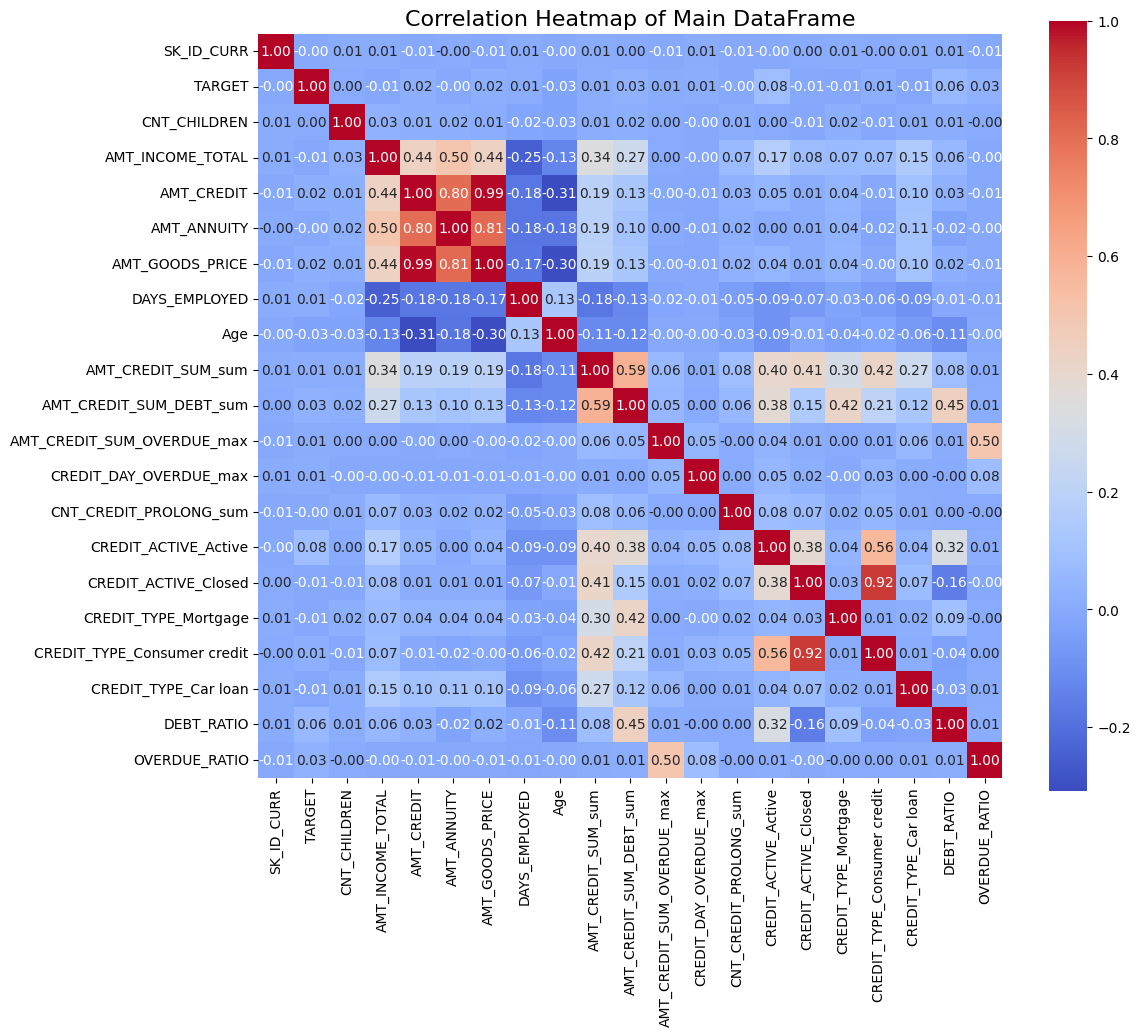

In [9]:
# Compute the correlation matrix
corr = main_df_numeric.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap
sns.heatmap(corr, 
            annot=True,       # show correlation values
            fmt=".2f",        # format to 2 decimal places
            cmap='coolwarm',  # color map
            cbar=True,        # show color bar
            square=True)

plt.title('Correlation Heatmap of Main DataFrame', fontsize=16)
plt.show()


In [10]:

corr_matrix = main_df_numeric.corr()

# Get upper triangle of the correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find pairs where correlation is above 0.5
high_corr = [(col, row, upper.loc[row, col]) 
             for col in upper.columns 
             for row in upper.index 
             if abs(upper.loc[row, col]) > 0.5]

# Convert to a DataFrame for easier viewing
high_corr_df = pd.DataFrame(high_corr, columns=['Column 1', 'Column 2', 'Correlation'])
high_corr_df


,Column 1,Column 2,Correlation
0,AMT_ANNUITY,AMT_INCOME_TOTAL,0.501527
1,AMT_ANNUITY,AMT_CREDIT,0.803714
2,AMT_GOODS_PRICE,AMT_CREDIT,0.989961
3,AMT_GOODS_PRICE,AMT_ANNUITY,0.814742
4,AMT_CREDIT_SUM_DEBT_sum,AMT_CREDIT_SUM_sum,0.587871
5,CREDIT_TYPE_Consumer credit,CREDIT_ACTIVE_Active,0.561537
6,CREDIT_TYPE_Consumer credit,CREDIT_ACTIVE_Closed,0.919932
7,OVERDUE_RATIO,AMT_CREDIT_SUM_OVERDUE_max,0.504315
